References:
- [State Space Models and the Kalman Filter](https://eml.berkeley.edu/~rothenbe/Fall2007/kalman.pdf)
- [Kalman filter and smoother](https://jwmi.github.io/ASM/6-KalmanFilter.pdf)
- [Optimal Smoothing](https://users.aalto.fi/~ssarkka/course_k2011/pdf/handout7.pdf)
- [Bayesian state-space models with PyMC3](https://github.com/luisroque/bayesian_time_series/blob/main/5%20Levels%20of%20Difficulty%20-%20Bayesian%20Gaussian%20Random%20Walk%20with%20PyMC3%20and%20Theano.ipynb)
- [AR models with PYMC3](https://www.pymc.io/projects/examples/en/latest/time_series/AR.html)
- [AR models with multiple inputs](https://discourse.pymc.io/t/multiple-time-series/5868/2)

In [68]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

import pymc3 as pm
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

from density_decoding.utils.utils import set_seed

seed = 666
set_seed(seed)

In [69]:
%matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 30
BIGGER_SIZE = 35
plt.rc('font', size=BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rc('axes', labelsize=BIGGER_SIZE)
plt.rc('axes', linewidth=1)
plt.rc('xtick', labelsize=BIGGER_SIZE)
plt.rc('ytick', labelsize=BIGGER_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=3)

In [79]:
dir_path = Path("/home/yizi/density_decoding/saved_results")

pids = [
    "dab512bd-a02d-4c1f-8dbc-9155a163efc0",
    "febb430e-2d50-4f83-87a0-b5ffbb9a4943",
    "84bb830f-b9ff-4e6b-9296-f458fb41d160",
    "523f8301-4f56-4faf-ab33-a9ff11331118",
]

test_pid = pids[0]
print(test_pid)

saved_y_obs, saved_y_hat = {}, {}
for brain_region in ["all", "po", "lp", "dg", "ca1", "vis"]:
    
    y_obs, y_hat, k_idx = [], [], []

    for i in range(5):
        y_obs.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_obs"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        y_hat.append(
            np.load(
                dir_path/test_pid/"prior"/brain_region/"y_pred"/f"fold_{i+1}.npy", allow_pickle=True
            ).item()["all_ks"]
        )
        k_idx.append(
            np.load(
                dir_path/test_pid/"choice"/brain_region/"trial_idx"/f"fold_{i+1}.npy", allow_pickle=True
            )
        )

    k_idx = np.concatenate(k_idx)
    y_obs = np.concatenate(y_obs)[np.argsort(k_idx)]
    y_hat = np.concatenate(y_hat)[np.argsort(k_idx)]
    
    saved_y_obs.update({brain_region: y_obs})
    saved_y_hat.update({brain_region: y_hat})

dab512bd-a02d-4c1f-8dbc-9155a163efc0


Kalman Filter and Smoothing

In [80]:
saved_smoothed_y, saved_metrics = {}, {}

brain_region = "ca1"

noise = 1e-3
Q = 1e-3

fk = KalmanFilter(dim_x=2, dim_z=1)

fk.x = np.array([0., 1.])      # state (x and dx)

fk.F = np.array([[1., 1.],
                 [0., 1.]])    # state transition matrix

fk.H = np.array([[1., 0.]])    # measurement function
fk.P *= 10.                    # covariance matrix
fk.R = noise                   # state uncertainty
fk.Q = Q_discrete_white_noise(dim=2, dt=1., var=Q)  # process uncertainty

# filter data with Kalman filter, than run smoother on it
mu, cov, _, _ = fk.batch_filter(saved_y_hat[brain_region])
M, P, C, _ = fk.rts_smoother(mu, cov)

saved_smoothed_y.update({brain_region: M[:,0]})
    
metrics = {}
metrics.update({
    "r2": {
        "smooth": r2_score(y_obs, M[:, 0]),
        "orig": r2_score(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "mse": {
        "smooth": mean_squared_error(y_obs, M[:, 0]),
        "orig": mean_squared_error(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "corr": {
      "smooth": pearsonr(y_obs, M[:, 0])[0],
      "orig": pearsonr(y_obs, saved_y_hat[brain_region])[0]
    },
})
saved_metrics.update({brain_region: metrics})

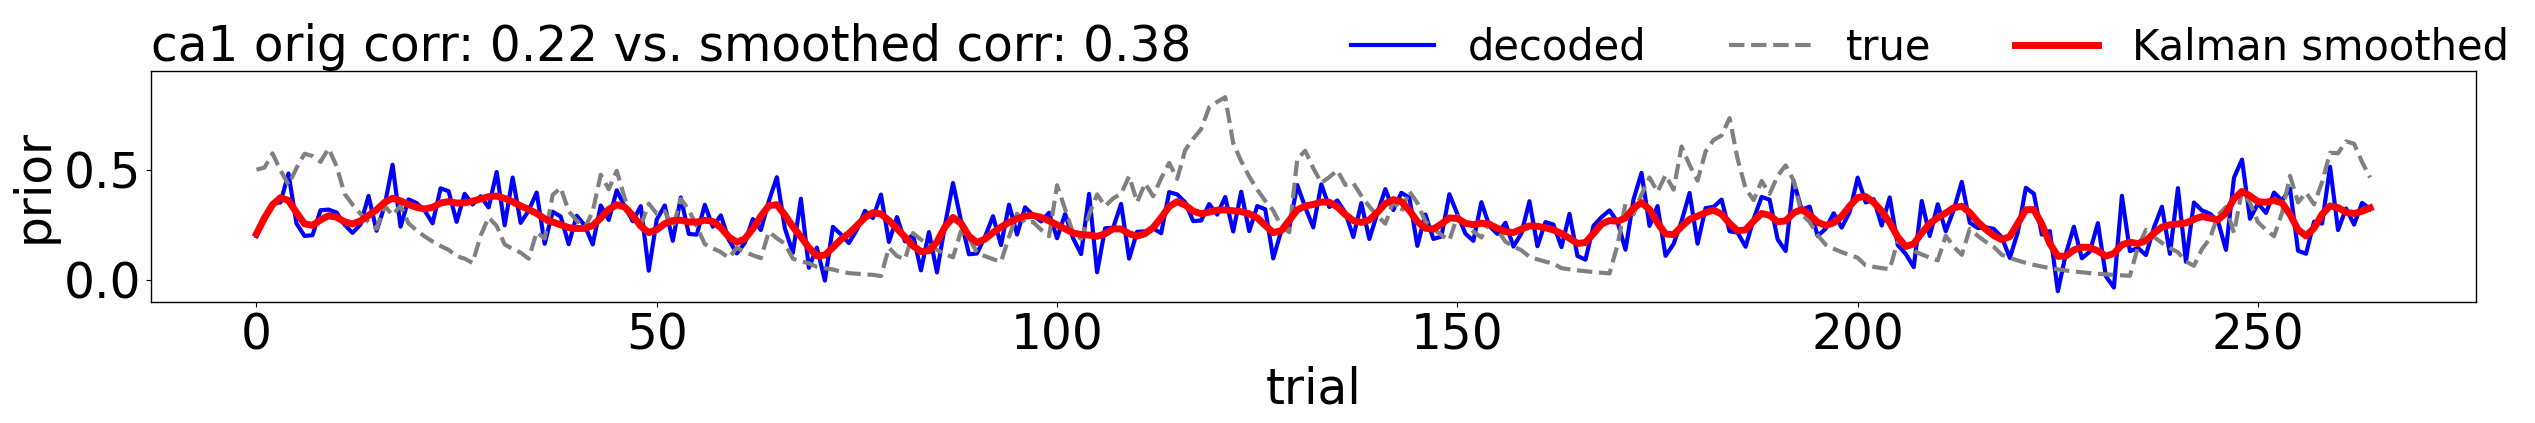

In [81]:
plt.figure(figsize=(30, 3))
plt.plot(saved_y_hat[brain_region], c="b", ls='-', linewidth=3, label="decoded")
plt.plot(saved_y_obs[brain_region], c="gray", ls='--', linewidth=3, label="true")
plt.plot(saved_smoothed_y[brain_region], c='r', linewidth=5, label='Kalman smoothed')
plt.xlabel("trial")
plt.ylabel("prior")
plt.title(f"{brain_region} orig corr: {saved_metrics[brain_region]['corr']['orig']:.2f} vs. smoothed corr: {saved_metrics[brain_region]['corr']['smooth']:.2f}", loc='left')
plt.ylim(-.1, 0.95)
plt.legend(ncols=3, loc='center left', bbox_to_anchor=(0.5, 1.1), fontsize=30, frameon=False)
plt.show()

Linear Gaussian state space model: $y_t$ is decoded prior and $x_t$ is true prior.

1. Dynamic model AR(1): 
    
$$x_t = \rho x_{t-1} + \xi_t, \quad \rho \sim \mathcal{N}(\mu_\rho, \sigma_\rho^2), \quad \xi_t \sim \mathcal{N}(0, \sigma_\xi^2)$$
        
2. Observation model:

$$y_t = \alpha + \beta x_{t-1} + \epsilon_t, \quad \alpha  \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha^2), \quad \beta  \sim \mathcal{N}(\mu_\beta, \sigma_\beta^2), \quad \epsilon_t \sim \mathcal{N}(0, \sigma_\epsilon^2)$$

In [82]:
seq_len = len(saved_y_hat[brain_region])

with pm.Model() as vanilla_ssm:
    
    # priors
    rho = pm.Normal("rho", mu=0, sigma=1, shape=1)
    sigma_xi = pm.HalfNormal("xi", sigma=1, shape=1)
    
    # low snr
    # alpha = pm.Normal("alpha", mu=0.5, sigma=1, shape=1)
    # beta = pm.Normal("beta", mu=0, sigma=1, shape=1)
    # high snr
    alpha = pm.Normal("alpha", mu=0, sigma=1, shape=1)
    beta = pm.Normal("beta", mu=1, sigma=1, shape=1)
    
    sigma_eps = pm.HalfNormal("eps", sigma=1, shape=1)
    
    # dynamic model AR(1)
    x = pm.AR1("state", k=rho, tau_e=1/sigma_xi, shape=seq_len)
    
    # observation model (linear-Gaussian)
    y = pm.Normal("obs", 
                  mu=alpha + beta * x, 
                  sigma=sigma_eps, 
                  observed=saved_y_hat[brain_region])
    
    trace = pm.sample(1000,
                      target_accept=0.95,
                      init='advi+adapt_diag',
                      tune=1000)  
    
    ppc = pm.sample_posterior_predictive(
        trace, var_names=["obs", "state", "beta", "alpha", "rho", "eps", "xi"], random_seed=seed
    )

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 68400
Interrupted at 68,399 [34%]: Average Loss = -117.45
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [state, eps, beta, alpha, xi, rho]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 30 seconds.
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 43 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8735471796583435, but should be close to 0.95. Try to increase the number of tuning steps.
There were 294 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7422033991262447, but should be close to 0.95. Try to increase the number of tuning steps.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8957020447335173, but should be close to 0.95. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimat

In [83]:
print(ppc["rho"].mean(0))
print(ppc["alpha"].mean(0))
print(ppc["beta"].mean(0))

[0.69929349]
[0.26495558]
[-0.00623626]


In [84]:
saved_smoothed_y = {}
saved_smoothed_y.update({brain_region: ppc["obs"].mean(0)})

In [85]:
metrics = {}
metrics.update({
    "r2": {
        "smooth": r2_score(y_obs, saved_smoothed_y[brain_region]),
        "orig": r2_score(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "mse": {
        "smooth": mean_squared_error(y_obs, saved_smoothed_y[brain_region]),
        "orig": mean_squared_error(y_obs, saved_y_hat[brain_region])
    }
})
metrics.update({
    "corr": {
      "smooth": pearsonr(y_obs, saved_smoothed_y[brain_region])[0],
      "orig": pearsonr(y_obs, saved_y_hat[brain_region])[0]
    },
})
saved_metrics.update({brain_region: metrics})

In [86]:
saved_metrics

{'ca1': {'r2': {'smooth': 0.11319706040870103, 'orig': -0.09028564965119501},
  'mse': {'smooth': 0.02884362142268287, 'orig': 0.035461978210870916},
  'corr': {'smooth': 0.4350073317085607, 'orig': 0.21929542664167276}}}

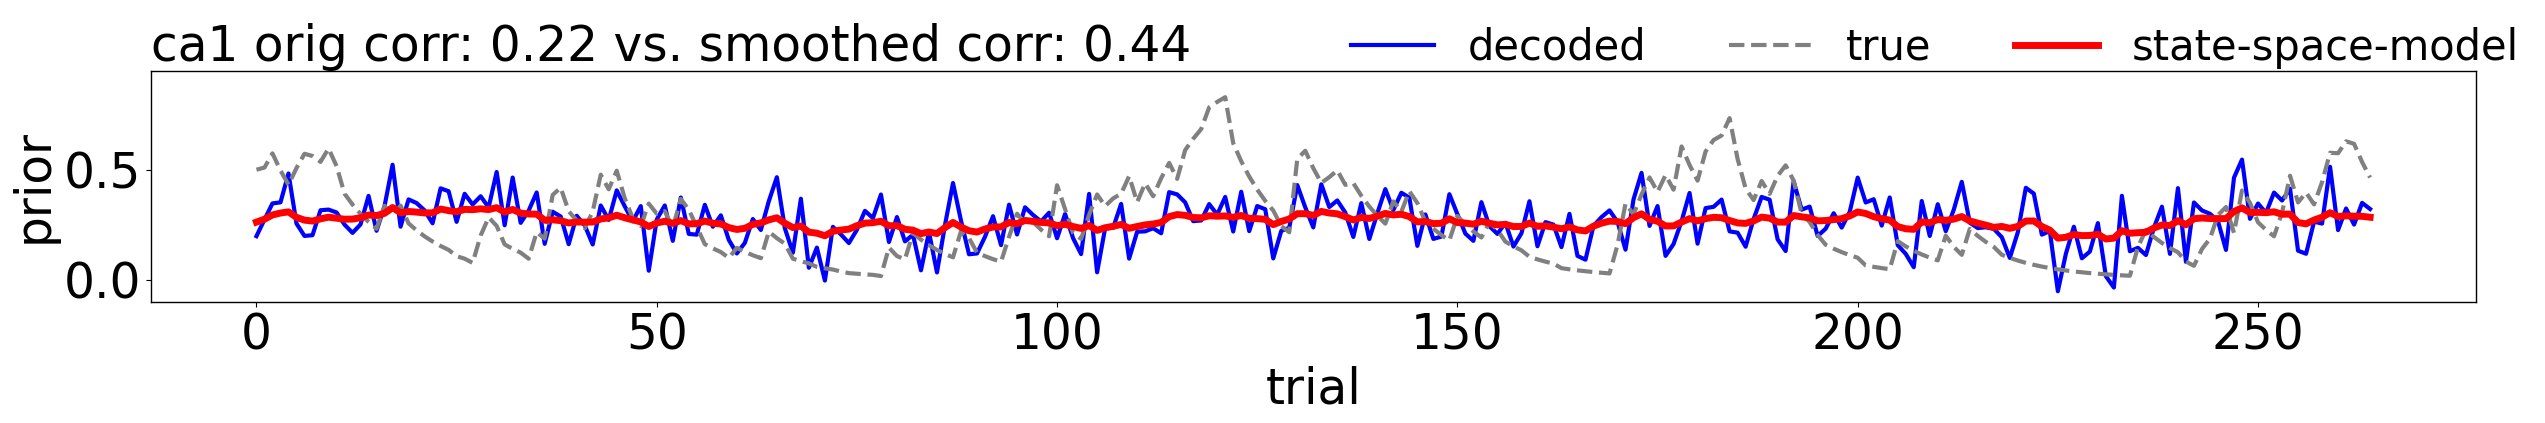

In [87]:
plt.figure(figsize=(30, 3))
plt.plot(saved_y_hat[brain_region], c="b", ls='-', linewidth=3, label="decoded")
plt.plot(saved_y_obs[brain_region], c="gray", ls='--', linewidth=3, label="true")
plt.plot(saved_smoothed_y[brain_region], c='r', linewidth=5, label='state-space-model')
plt.xlabel("trial")
plt.ylabel("prior")
plt.title(f"{brain_region} orig corr: {saved_metrics[brain_region]['corr']['orig']:.2f} vs. smoothed corr: {saved_metrics[brain_region]['corr']['smooth']:.2f}", loc='left')
plt.ylim(-.1, 0.95)
plt.legend(ncols=3, loc='center left', bbox_to_anchor=(0.5, 1.1), fontsize=30, frameon=False)
plt.show()